### Homework 3.3 - Please Help The Cat

A poor cat is trapped on canvas by an evil witch. Please help releasing the cat by breaking the curse using Discrete Fourier Transform learned in our magic class.

You may find the image at `images/poor-cat-trapped-on-canvas.jpg`. Note that the image has 3 color channels (RGB).

Please remember that the examples shown in class uses the book of spells from the ancient library. Try searching the newer spells on the internet.

**You must show all the steps clearly. Write your explanation in the markdown boxes.**

<img src="images/poor-cat-trapped-on-canvas.jpg" alt="A poor cat trapped on canvas" width="400">

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

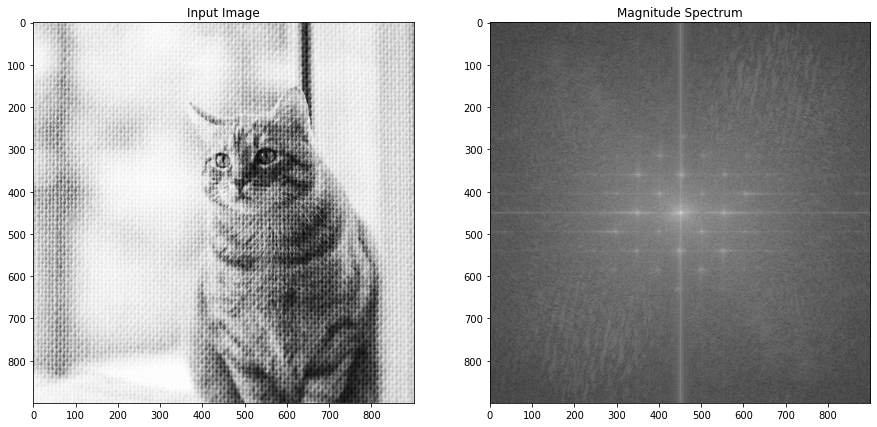

In [2]:
imgP = 'images/poor-cat-trapped-on-canvas.jpg'
img = cv2.imread(imgP, 0)
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = [np.log(np.abs(z)+1) for z in fshift]

plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(img, cmap='gray')
plt.title('Input Image')
plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum')
plt.show()

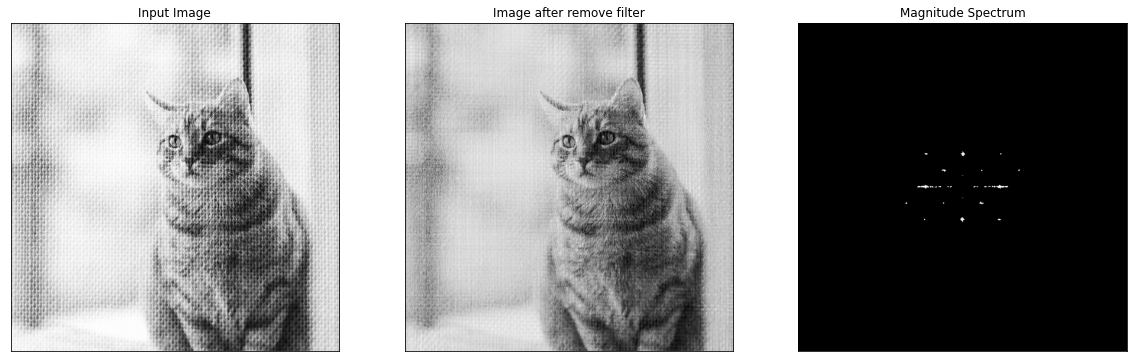

In [11]:
# read input as grayscale
img = cv2.imread(imgP, 0)

# get min and max values of img
img_min, img_max = np.amin(img, (0, 1)), np.amax(img, (0, 1))

# convert image to floats and do dft saving as complex output
dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)

# apply shift of origin from upper left corner to center of image
dft_shift = np.fft.fftshift(dft)

# extract magnitude and phase images
mag, phase = cv2.cartToPolar(dft_shift[:, :, 0], dft_shift[:, :, 1])

# get spectrum
spec = np.log(mag) / 20

# create mask from spectrum keeping only the brightest spots as the notches
mask = cv2.normalize(spec, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
mask = cv2.threshold(mask, 0.65, 1, cv2.THRESH_BINARY)[1]

# dilate mask
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel)

# cover center DC component by circle of black leaving only a few white spots on black background
xcenter = mask.shape[1] // 2
ycenter = mask.shape[0] // 2
mask = cv2.circle(mask, (xcenter, ycenter), radius=30,
                  color=0, thickness=cv2.FILLED)

# apply mask to magnitude such that magnitude is made zero where mask is one, ie at spots
mag[mask != 0] = 0

# convert new magnitude and old phase into cartesian real and imaginary components
real, imag = cv2.polarToCart(mag, phase)

# combine cartesian components into one complex image
back = cv2.merge([real, imag])

# shift origin from center to upper left corner
back_ishift = np.fft.ifftshift(back)

# do idft saving as complex output
img_back = cv2.idft(back_ishift)

# combine complex components into original image again
img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])

# re-normalize to 8-bits in range of original
Nmin, Nmax = np.amin(img_back, (0, 1)), np.amax(img_back, (0, 1))
no_fl = cv2.normalize(img_back, None, alpha=img_min,
                        beta=img_max, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

plt.figure(figsize=(20, 20))
plt.subplot(131), plt.imshow(img, cmap='gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(no_fl, cmap='gray')
plt.title('Image after remove filter'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(mask, cmap='gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()